In [291]:
!pip install matplotlib
!pip install sklearn
!pip install contractions


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [292]:
import pandas as pd
import numpy as np

df = pd.read_csv('generated_questions.csv')
df.head

<bound method NDFrame.head of                                               question         label
0    What are some ways to adjust to Swedish cultur...       CULTURE
1    How can you integrate into Swedish society as ...       CULTURE
2    What cultural norms should you be aware of whe...       CULTURE
3    How can you learn more about Swedish customs a...       CULTURE
4    What are some common challenges that people fa...       CULTURE
..                                                 ...           ...
475  What if I need to make changes to my appointme...  BANK ACCOUNT
476  Can I make an appointment to open a bank accou...  BANK ACCOUNT
477  How to find the nearest branch location to sch...  BANK ACCOUNT
478  Are there any requirements to meet before book...  BANK ACCOUNT
479  How soon can I open a bank account after sched...  BANK ACCOUNT

[480 rows x 2 columns]>

In [293]:
data = [item[0] for item in df.values]
labels = [item[1] for item in df.values]
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

In [294]:
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [295]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.043 s
n_samples: 480, n_features: 99


In [296]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=5,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

Number of elements asigned to each cluster: [ 93  99  96  60 132]
Number of elements asigned to each cluster: [ 59  97 190  70  64]
Number of elements asigned to each cluster: [ 78  89  60 213  40]
Number of elements asigned to each cluster: [ 71  95  99 155  60]
Number of elements asigned to each cluster: [ 60 101 100  88 131]
clustering done in 0.49 ± 0.33 s 
Homogeneity: 0.542 ± 0.047
Completeness: 0.567 ± 0.031
V-measure: 0.554 ± 0.039
Adjusted Rand-Index: 0.408 ± 0.049
Silhouette Coefficient: 0.125 ± 0.005


In [297]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_tfidf,
    name="MiniBatchKMeans\n on tf-idf vectors",
)

clustering done in 0.56 ± 0.34 s 
Homogeneity: 0.470 ± 0.060
Completeness: 0.509 ± 0.052
V-measure: 0.488 ± 0.056
Adjusted Rand-Index: 0.355 ± 0.083
Silhouette Coefficient: 0.108 ± 0.006


In [298]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(data)
print(f"vectorization done in {time() - t0:.3f} s")

fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")



vectorization done in 3.971 s
clustering done in 0.12 ± 0.07 s 
Homogeneity: 0.578 ± 0.057
Completeness: 0.629 ± 0.045
V-measure: 0.602 ± 0.051
Adjusted Rand-Index: 0.422 ± 0.066
Silhouette Coefficient: 0.098 ± 0.001


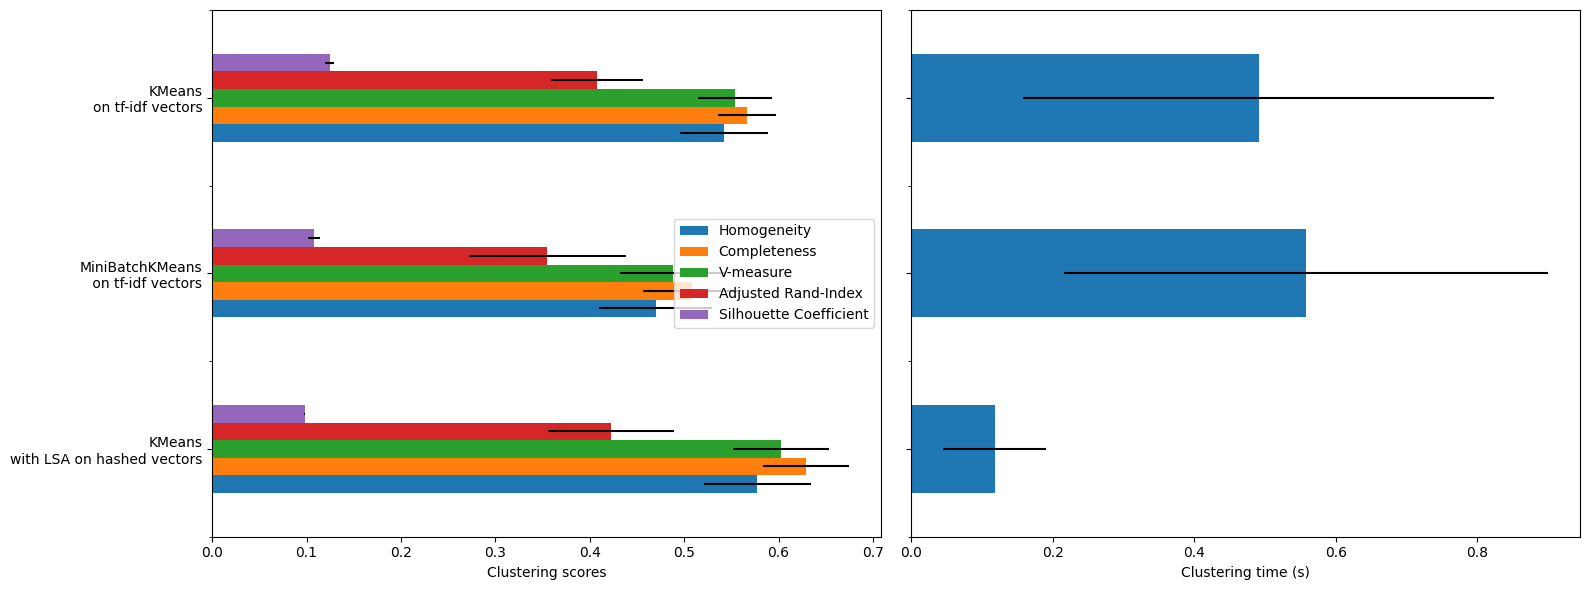

In [299]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()